## Exercises
The Traveling Salesman Problem (TSP) is: “Given is a list of cities and distances between each
pair of cities - what is the shortest route that visits each city and returns to the original city?”
Consider the symmetric variant of the TSP (sTSP), where the cost from city j to city i equals the
cost from city i to city j.

1. Download the TSPLIB dataset, which contains graphs with cities as nodes & the
distances between them, either in tsp or XML format
http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/
The documentation is available in :
http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp95.pdf 

2. Consider the following datasets: rd100.tsp, eil101.tsp, a280.tsp, d198.tsp and
ch150.tsp. For each dataset:\
a. Compute the distance matrices between cities.\
b. Assess the performance of three Hill Climbing Algorithms in solving the TSP.\
i. Simple Hill Climbing\
ii. Stochastic Hill Climbing\
c. Tabulate results and comment on the best local search method for all datasets.

### Importing Libraries

In [58]:
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from python_tsp.distances import tsplib_distance_matrix
import numpy as np
from tqdm import tqdm

### 1. Download the TSPLIB dataset in tsp  format.

In [79]:
datasets = ['rd100.tsp', 'eil101.tsp', 'ch150.tsp', 'd198.tsp', 'a280.tsp']

###

### a. Compute the distance matrices between cities.

In [83]:
for i in datasets:
    print(i)
    print(tsplib_distance_matrix(i))
    print('\n')

rd100.tsp
[[   0 1134  421 ...  766  544  820]
 [1134    0  807 ...  415  643  414]
 [ 421  807    0 ...  397  164  622]
 ...
 [ 766  415  397 ...    0  236  386]
 [ 544  643  164 ...  236    0  485]
 [ 820  414  622 ...  386  485    0]]


eil101.tsp
[[ 0 33 15 ... 31 39 15]
 [33  0 34 ... 17 17 18]
 [15 34  0 ... 40 46 22]
 ...
 [31 17 40 ...  0  8 17]
 [39 17 46 ...  8  0 24]
 [15 18 22 ... 17 24  0]]


ch150.tsp
[[  0 577 188 ... 770 270 379]
 [577   0 591 ... 368 607 615]
 [188 591   0 ... 688  83 194]
 ...
 [770 368 688 ...   0 657 600]
 [270 607  83 ... 657   0 113]
 [379 615 194 ... 600 113   0]]


d198.tsp
[[   0 1139 1177 ... 4172 4153 4079]
 [1139    0   76 ... 3478 3477 3401]
 [1177   76    0 ... 3402 3401 3325]
 ...
 [4172 3478 3402 ...    0   76  108]
 [4153 3477 3401 ...   76    0   76]
 [4079 3401 3325 ...  108   76    0]]


a280.tsp
[[ 0 20 24 ... 43 34 18]
 [20  0 18 ... 36 28  9]
 [24 18  0 ... 20 11 10]
 ...
 [43 36 20 ...  0  9 29]
 [34 28 11 ...  9  0 20]
 [18  9 1

### b. Assess the performance of Hill Climbing Algorithms in solving the TSP.

In [84]:
#Function to read cordinates from .tsp files.
def load_data(filename):
    with open(filename, "r") as f:
        V = []
        data = f.readlines()
        for i, line in enumerate(data):
            if line.startswith("NODE_COORD_SECTION"):
                data = data[i+1:len(data)-1]
                break
        for i, line in enumerate(data):
            node = line.split()[1:]
            node = np.array([float(i) for i in node])
            V.append(node)
        cities = {i : V[i] for i in range(len(V))}
    return cities

In [85]:
#Simple function for calculating Euclidian distance between two points.
def euclid_distance(x,y):
    # x and y are numpy arrays
    return np.sqrt(np.sum((x-y)**2))

In [8]:
#Function to calculate all paths possible in tsp .
def calculate_paths(cities:dict):
    names = [i for i in range(len(cities))]
    paths = np.zeros((len(names), len(names)))
    for i in range(len(names)):
        for j in range(len(names)):
            if i != j:
                paths[i,j] = euclid_distance(cities[names[i]], cities[names[j]])
    return paths

In [9]:
#Initial tour/path.
def initialize_tour(paths):

    num_cities = paths.shape[0]
    visited = [False] * num_cities
    tour = [np.random.randint(0, num_cities)]
    visited[tour[0]] = True

    while len(tour) < num_cities:
        current_city = tour[-1]
        nearest_city = None
        nearest_distance = float('inf')

        # Find the nearest unvisited city to the current city
        for city in range(num_cities):
            if not visited[city] and paths[current_city, city] < nearest_distance:
                nearest_city = city
                nearest_distance = paths[current_city, city]

        tour.append(nearest_city)
        visited[nearest_city] = True

    return tour

In [10]:
#Function to get neighbours near a point (to decide path).
def generate_neighbors(x, n=10):
    neighbors = []
    while len(neighbors) < n:
        i = np.random.randint(0, len(x)-2)
        j = np.random.randint(1, len(x)-1)
        if i > j :
            i, j = j, i
        neighbor = x.copy()
        neighbor[i:j] = neighbor[i:j][::-1]
        if tuple(neighbor) not in map(tuple, neighbors):
            neighbors.append(neighbor)
    return neighbors

In [86]:
#Cost of chosen path.
def fitness(x, paths):
    # x is a list of cities
    fitness = 0
    for i in range(len(x)-1):
        fitness += paths[x[i], x[i+1]]
    fitness += paths[x[-1], x[0]]
    return fitness

### i. Simple Hill Climbing

In [88]:
#Chooses neighbour with least cost (edge weight). Simple Hill Climbing.
def best_neighbor(x:list, paths:np.array, generate_neighbors:callable = generate_neighbors, fitness: callable = fitness):
    neighbors = generate_neighbors(x)
    best_neighbor = neighbors[0]
    for neighbor in range(1, len(neighbors)):
        if fitness(neighbors[neighbor], paths) < fitness(best_neighbor, paths):
            best_neighbor = neighbors[neighbor]
    return best_neighbor

### ii. Stochastic Hill Climbing

In [11]:
#Chooses random neighbour. Used in Stochastic Hill Climbing.
def random_neighbor(x:list, paths:np.array, generate_neighbors:callable = generate_neighbors):
    neighbors = generate_neighbors(x)
    return neighbors[np.random.randint(0, len(neighbors))]

In [89]:
#Function to read cordinates from .opt.tour files.
def load_city_coordinates(filename):
    city_coords = []
    with open(filename, 'r') as file:
        reading_coords = False
        for line in file:
            if line.strip() == "EOF":
                break
            if reading_coords:
                parts = line.strip().split()
                city_coords.append([float(parts[1]), float(parts[2])])
            if line.strip() == "NODE_COORD_SECTION":
                reading_coords = True
    return np.array(city_coords)

#Calculate the total cost of tour.
def calculate_tour_distance(city_coords, tour):
    total_distance = 0
    for i in range(len(tour) - 1):
        city1 = tour[i] - 1  # Adjust for 0-based indexing
        city2 = tour[i + 1] - 1
        total_distance += euclid_distance(city_coords[city1], city_coords[city2])
    # Add distance from last city back to the starting city
    total_distance += euclid_distance(city_coords[tour[-1] - 1], city_coords[tour[0] - 1])
    return total_distance

#Load the optimal tour from the rd100.opt.tour file
def optimal_tour(filename,tspfile):
    optimal_tour = []
    with open(filename, 'r') as file:
        reading_tour = False
        for line in file:
            if reading_tour:
                if line.strip() == "-1" or line.strip() == "EOF":
                    break
                optimal_tour.extend(map(int, line.strip().split()))
            if line.strip() == "TOUR_SECTION":
                reading_tour = True
    return calculate_tour_distance(load_city_coordinates(tspfile), optimal_tour)

#Function that uses all above functions to finally perform hill climbing.
def hill_climbing(f:callable, x_init:float, n_iters:int, paths:np.array, variant:str, epsilon:float = 0.001, steepest:bool = False):
    # choose intial x randomly as x_best
    x = x_init
    x_best = x
    if variant == "simple":
        neighbor_function = best_neighbor
    elif variant == "stochastic":
        neighbor_function = random_neighbor
    for i in tqdm(range(n_iters)):
        y = neighbor_function(x, paths)
        if f(x, paths) > f(y, paths) :
            x = y
            if f(x, paths) < f(x_best, paths):
                x_best = x
            else:
                if steepest:
                    x = x_best
    return x_best

### c. Tabulate results and comment on the best local search method for all datasets.

In [94]:
simple_fitness = []
stochastic_fitness = []
optimal_distances = []

for dataset in datasets:
    data = load_data(dataset)
    paths = calculate_paths(data)
    x_init = initialize_tour(paths)
    
    #Perform hill climbing with simple variant.
    simple_fitness.append(fitness(hill_climbing(f=fitness,x_init=initialize_tour(calculate_paths(load_data(dataset))),n_iters=100,
                        paths=calculate_paths(load_data(dataset)),variant="simple"),calculate_paths(load_data(dataset))))
    
    #Perform hill climbing with stochastic variant.
    stochastic_fitness.append(fitness(hill_climbing(f=fitness,x_init=initialize_tour(calculate_paths(load_data(dataset))),n_iters=100,
                        paths=calculate_paths(load_data(dataset)),variant="stochastic"),calculate_paths(load_data(dataset))))
    
    #Calculate optimal tour distance.
    optimal_distances.append(optimal_tour(dataset.replace('.tsp', '.opt.tour'), dataset))

#Create DataFrame.
df = pd.DataFrame({
    'Dataset': datasets,
    'Simple Fitness': simple_fitness,
    'Stochastic Fitness': stochastic_fitness,
    'Optimal Fitness': optimal_distances
})

df['Simple Fitness Accuracy']=df['Optimal Fitness']/df['Simple Fitness']
df['Stochastic Fitness Accuracy']=df['Optimal Fitness']/df['Stochastic Fitness']
df

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 5708.87it/s]


,Dataset,Simple Fitness,Stochastic Fitness,Optimal Fitness,Simple Fitness Accuracy,Stochastic Fitness Accuracy
0,rd100.tsp,9065.876303,9864.349233,7910.396210,0.872546,0.801918
1,eil101.tsp,737.870522,773.880660,642.309536,0.870491,0.829985
2,ch150.tsp,7583.583296,8114.438945,6532.280933,0.861371,0.805019
3,d198.tsp,18883.805248,19136.855269,15809.660734,0.837207,0.826137
4,a280.tsp,3252.414986,3209.528434,2586.769648,0.795338,0.805966


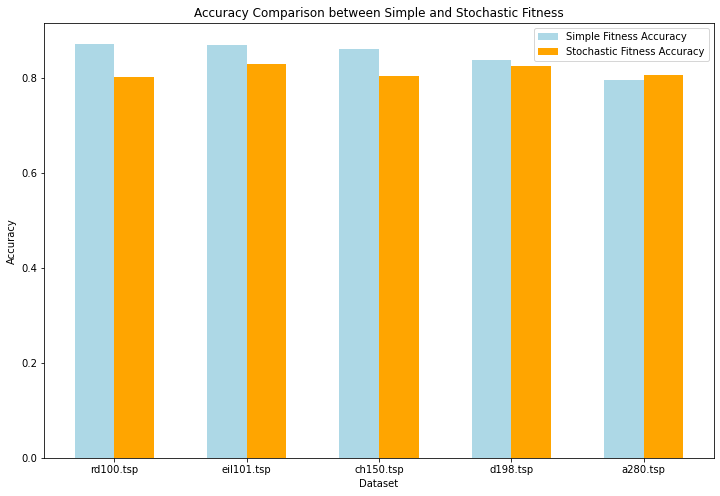

In [95]:
#Plotting results.
plt.figure(figsize=(12, 8))

bar_width = 0.3
index = np.arange(len(df['Dataset']))

plt.bar(index - bar_width/2, df['Simple Fitness Accuracy'], bar_width, color='lightblue', label='Simple Fitness Accuracy')
plt.bar(index + bar_width/2, df['Stochastic Fitness Accuracy'], bar_width, color='orange', label='Stochastic Fitness Accuracy')

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between Simple and Stochastic Fitness')
plt.xticks(index, df['Dataset'])
plt.legend()
plt.show()

###  Stochastic Hill Climbing works better for datasets with less nodes but as we increase nodes, Simple Hill Climbing works better.